In [2]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=aa34cb4a4c85ee7b93b727f56d3b82c66678941578d74d826b6ac1dfe33e97bf
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime



📘 X_train_scaled DataFrame:
        BVP       EDA      TEMP         X         Y         Z        HR  \
0 -0.471120 -0.659270  0.258455 -0.002032 -0.605395  0.756258 -0.807135   
1 -0.087365 -0.674260  0.050494 -1.164615 -0.097261 -0.545259 -0.538412   
2  0.013315  0.858887  1.228937  0.742022  0.254524  1.123352  1.098095   
3  0.212290 -0.700028 -0.189460  0.369995 -1.973448 -0.311654 -0.915398   
4  0.038024  0.059074  0.290449  1.579082  1.153531  1.023235 -0.364418   

      Delta     Theta    Alpha1    Alpha2     Beta1     Beta2    Gamma1  \
0  1.699961 -0.688622  1.249073 -0.587974 -0.725217  0.883266 -0.709403   
1  0.390992 -0.660252 -0.725355 -0.263095 -0.722949 -0.711458 -0.475862   
2 -0.690126 -0.683329 -0.127544 -0.660055  0.054753  0.033733 -0.605752   
3  2.078938 -0.286534  1.287965  1.230047  0.011405  1.768263 -0.673554   
4  0.645086  0.776228 -0.691491  1.234611  1.320024  1.267352 -0.716893   

     Gamma2  Attention  Meditation  
0  2.532636   1.287393   -0.6678

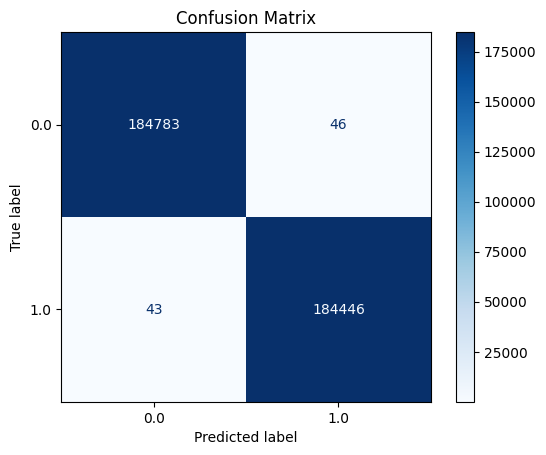

   Sample  Predicted_Class  Uncertainty (1 - max prob)
0       0              1.0                         0.0
1       1              0.0                         0.0
2       2              1.0                         0.0
3       3              1.0                         0.0
4       4              1.0                         0.0


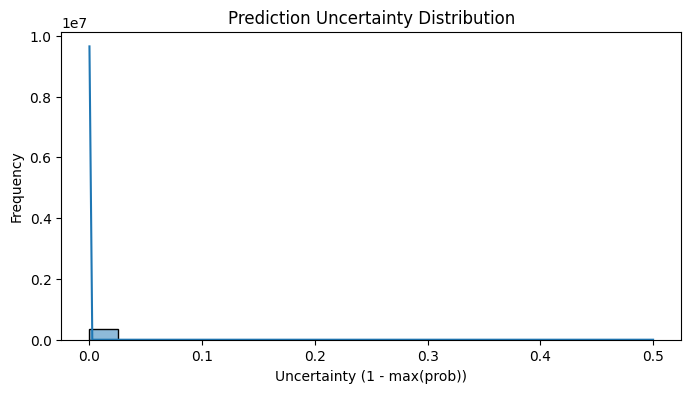


🟡 LIME Explanation for First Sample:
[('TEMP > 0.75', 0.1454893155094224), ('HR > 0.58', -0.13499548118792268), ('-0.65 < EDA <= -0.43', -0.07964596870554323), ('Attention <= -0.87', 0.036113537582595945), ('-0.64 < Delta <= -0.39', 0.026857681585674753), ('-0.61 < Z <= 0.26', -0.023703218048226074), ('Gamma1 <= -0.65', -0.019013963373596225), ('Theta <= -0.62', 0.016812797034636843), ('0.03 < BVP <= 0.33', 0.00876563135614802), ('Alpha2 <= -0.64', -0.008484911425935028)]


 96%|=================== | 193/200 [00:27<00:00]       

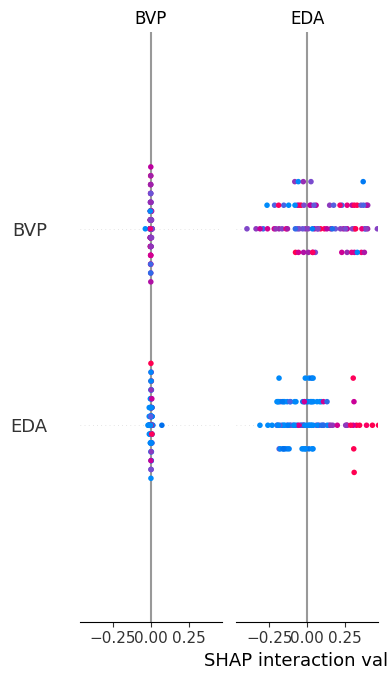


✅ Results saved to 'M5Prime_Classifier_Results.xlsx'


In [3]:
# oselm_uncertainty_xai.py with M5 Prime Classifier integration

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

import warnings
warnings.filterwarnings("ignore")


class M5PrimeClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, min_samples_split=20):
        self.min_samples_split = min_samples_split
        self.tree = DecisionTreeClassifier(min_samples_split=self.min_samples_split)
        self.leaf_class_votes = {}

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.tree.fit(X, y)
        self.classes_ = np.unique(y)
        leaves = self.tree.apply(X)
        self.leaf_class_votes = {}
        for leaf in np.unique(leaves):
            idx = np.where(leaves == leaf)[0]
            if len(idx) > 0:
                values, counts = np.unique(y[idx], return_counts=True)
                self.leaf_class_votes[leaf] = dict(zip(values, counts))
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        leaves = self.tree.apply(X)
        preds = []
        for leaf in leaves:
            votes = self.leaf_class_votes.get(leaf, {})
            if votes:
                pred_class = max(votes, key=votes.get)
            else:
                pred_class = self.tree.classes_[0]
            preds.append(pred_class)
        return np.array(preds)

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        leaves = self.tree.apply(X)
        proba = np.zeros((X.shape[0], len(self.classes_)))
        for i, leaf in enumerate(leaves):
            votes = self.leaf_class_votes.get(leaf, {})
            total = sum(votes.values())
            for cls, count in votes.items():
                proba[i, np.where(self.classes_ == cls)[0][0]] = count / total
        return proba


def compute_uncertainty(probs):
    return 1 - np.max(probs, axis=1)


def main():
    data = pd.read_csv("/content/drive/MyDrive/CODE/Prince Okyere/UP/MEFAR_UP.csv")
    data.dropna(inplace=True)
    label_encoder = LabelEncoder()
    data['class'] = label_encoder.fit_transform(data['class'])
    classes = label_encoder.classes_.astype(str)

    X = data.drop('class', axis=1)
    y = data['class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = M5PrimeClassifier(min_samples_split=10)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_probs = model.predict_proba(X_test_scaled)

    # Convert arrays to DataFrames for display
    X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    y_pred_df = pd.DataFrame({"Predicted Class": label_encoder.inverse_transform(y_pred)})
    y_pred_probs_df = pd.DataFrame(y_pred_probs, columns=[f"Class_{cls}" for cls in label_encoder.classes_])

    # Display the first few rows
    print("\n📘 X_train_scaled DataFrame:")
    print(X_train_df.head())

    print("\n📗 X_test_scaled DataFrame:")
    print(X_test_df.head())

    print("\n📙 Predicted Class DataFrame:")
    print(y_pred_df.head())

    print("\n📕 Predicted Probabilities DataFrame:")
    print(y_pred_probs_df.head())





    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=classes)
    cm = confusion_matrix(y_test, y_pred)

    print("\n📊 Classification Report:\n", report)

    youden_index = np.nan
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp)
        sensitivity = recall_score(y_test, y_pred)
        youden_index = sensitivity + specificity - 1

    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    uncertainties = compute_uncertainty(y_pred_probs)
    uncertainty_df = pd.DataFrame({
        "Sample": np.arange(len(uncertainties)),
        "Predicted_Class": label_encoder.inverse_transform(y_pred),
        "Uncertainty (1 - max prob)": uncertainties
    })
    print(uncertainty_df.head())

    plt.figure(figsize=(8, 4))
    sns.histplot(uncertainties, bins=20, kde=True)
    plt.title("Prediction Uncertainty Distribution")
    plt.xlabel("Uncertainty (1 - max(prob))")
    plt.ylabel("Frequency")
    plt.show()

    lime_exp = LimeTabularExplainer(X_train_scaled, feature_names=X.columns,
                                    class_names=classes, discretize_continuous=True)
    lime_result = lime_exp.explain_instance(X_test_scaled[0], model.predict_proba, num_features=10)
    print("\n🟡 LIME Explanation for First Sample:")
    print(lime_result.as_list())

    rf = RandomForestClassifier()
    rf.fit(X_train_scaled, y_train)

    explainer = shap.Explainer(rf, X_train_scaled)
    shap_values = explainer(X_test_scaled[:100])
    shap.summary_plot(shap_values, X_test.iloc[:100], show=True)


    results_df = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "MCC", "Youden Index"],
        "Value": [acc, prec, rec, f1, mcc, youden_index]
    })
    results_df.to_excel("M5Prime_Classifier_Results.xlsx", index=False)
    print("\n✅ Results saved to 'M5Prime_Classifier_Results.xlsx'")


if __name__ == "__main__":
    main()
